In [169]:
from modules import EncoderNet,DecoderNet,DiscriminatorNet_reconstruction,GeneratorNet
from network import transformNet

import matplotlib.pylab as plt
import resnet
import invresnet
from dataload import load_data ,batchfy 
from torchsummary import summary
import torch
from torch import nn,optim
import numpy as np
import random
import torch
import time
from torchvision import transforms, utils
TIMEOUT=300

In [2]:


%load_ext autoreload
%autoreload 2
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.set_default_tensor_type(torch.cuda.FloatTensor)

In [132]:
Encoder=torch.load("Encoder_64batch.h")
#Encoder=resnet.resnet18()
#Encoder=Encoder.to(device)

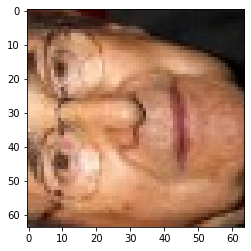

In [129]:
train_load,test_load=batchfy(batch_size=100)
show_img=iter(train_load)
for batch_i, (real_images, gender,glasses) in enumerate(train_load):
    debug=real_images[0]
    plt.imshow((debug.numpy().transpose((1, 2, 0))*0.5)+0.5)
    break

In [6]:
phi=transformNet.phi()
phi.to(device)

invphi=transformNet.phi(inv=True)
invphi.to(device)

phi(
  (fc1): Linear(in_features=99, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=99, bias=True)
)

In [130]:
opt_phi = optim.Adam(phi.parameters(), lr=0.0001, betas=(0.9, 0.999))
opt_invphi = optim.Adam(invphi.parameters(), lr=0.001, betas=(0.9, 0.999))
#criterion = nn.BCELoss()

In [181]:
def TripleletLoss(batch,targetAttribute):
    def triplet(value, positive, negative, margin=0.2) : 
        d = nn.PairwiseDistance(p=2)
        distance = d(value, positive) - d(value, negative) + margin 
        loss = torch.mean(torch.max(distance, torch.zeros_like(distance))) 
        return loss
    
    def findtriplet(src,attribute):
        timeout_start = time.time()
        index_list=np.arange(len(attribute)).tolist()
        rand=random.sample(index_list,len(attribute))
        for i,posindex in enumerate(rand):
            if attribute[src]==attribute[posindex]:
                if src != posindex:
                        break      
            if i==len(attribute)-1:
                print("reached_end")
            
        rand=random.sample(index_list,len(attribute))                
        for i,negindex in enumerate(rand):
            if(attribute[src] !=attribute[negindex]):
                break   
            if i==len(attribute)-1:
                print("reached_end")
                
        return posindex,negindex
    loss=0
    pos_pair=None
    for i,value in enumerate(batch):
        posindex,negindex=findtriplet(i,targetAttribute)

        if not i:

            pos_pair=batch[posindex].unsqueeze(0)
            neg_pair=batch[negindex].unsqueeze(0)
        else:
            pos_pair=torch.cat((pos_pair,batch[posindex].unsqueeze(0)),0)
            neg_pair=torch.cat((neg_pair,batch[negindex].unsqueeze(0)),0)


    return triplet(batch,pos_pair,neg_pair)

        

In [182]:
TripleletLoss(glass_vector,glasses)

tensor(0.2068, grad_fn=<MeanBackward0>)

In [183]:
def train(Encoder,phi,invphi,train_load,num_epochs=40):
    t_start = time.time()
    Encoder.eval()
    phi.train()
    invphi.train()
    for epoch in range(num_epochs):
        print("Epoch:", epoch)
        for batch_i, (real_images, gender,glasses) in enumerate(train_load):
            batch_size = real_images.size(0)
            real_images=real_images.to(device,dtype=torch.float)
            latent_vector=Encoder(real_images).detach()
            glass_vector,gender_vector,remain=phi(latent_vector)
            remain=remain.detach()
            opt_phi.zero_grad()       
            loss=TripleletLoss(glass_vector,glasses) +    TripleletLoss(gender_vector,gender)     
            loss.backward()
            
            opt_phi.zero_grad()
            opt_phi.step
            
            
            
            if (batch_i) % 10 == 0:
                print("Batch: ", batch_i)
                print(loss.item())
        t_end = time.time()
        duration_avg = (t_end - t_start) / (epoch + 1.0)
        print("Elapsed Time: ",duration_avg)
    return 

In [184]:
train(Encoder,phi,invphi,train_load,num_epochs=5)




Epoch: 0
Batch:  0
0.4438566565513611
Batch:  10
0.3672652542591095
Batch:  20
0.4202374815940857
reached_end
Batch:  30
0.43779852986335754
Batch:  40
0.44448965787887573


KeyboardInterrupt: 

In [154]:
TripleletLoss(c1,c2)

tensor(0.2003, grad_fn=<MeanBackward0>)

In [22]:

glass_vector,gender_vector,remain=phi(sample_output.to(device))
loss=TripleletLoss(glass_vector,glasses)


torch.Size([100, 33])
torch.Size([33])


In [ ]:
loss[0],loss[1],loss[2]
loss[0].shape

In [ ]:
d = nn.PairwiseDistance(p=2)

In [69]:
one=sample_batch[0].detach().cpu()
two=sample_batch[posindex].detach().cpu()
three=sample_batch[negindex].detach().cpu()
show=torch.stack([one,two,three],dim=0)

torch.Size([100, 99])

In [106]:
test=torch.tensor([[1, 2, 3], [4, 5, 6]],dtype=float)

In [107]:
test1=torch.tensor([[4, 5, 6], [1, 2, 3]],dtype=float)

In [108]:
d = nn.PairwiseDistance(p=2)

d(test,test1)

tensor([5.1962, 5.1962], dtype=torch.float64)

In [109]:
def triplet(value, positive, negative, margin=0.2) : 
        d = nn.PairwiseDistance(p=2)
        distance = d(value, positive) - d(value, negative) + margin 
        loss = torch.mean(torch.max(distance, torch.zeros_like(distance))) 
        return loss

In [110]:
triplet(test,test1,test1)

tensor(0.2000, dtype=torch.float64)

In [111]:
test.shape

torch.Size([2, 3])

In [11]:
def findtriplet(src,attribute):
        timeout_start = time.time()
        while time.time() < timeout_start + TIMEOUT:
            posindex = random.choice(range(len(attribute)))
            if attribute[src]==attribute[posindex]:
                if src != posindex:
                        break
        while time.time() < timeout_start + TIMEOUT:
            negindex = random.choice(range(len(attribute)))
            if(attribute[src] !=attribute[negindex]):
                break   
        return posindex,negindex

In [14]:
test1=None


In [99]:
test=torch.tensor([1, 2, 3],dtype=float).unsqueeze(0)
test1=torch.tensor([1, 2, 3],dtype=float).unsqueeze(0)
#test=test.unsqueeze(0)

In [100]:
test.shape

torch.Size([1, 3])

In [101]:
test2=torch.cat((test1,test),0)

In [102]:
test2=torch.cat((test2,test1),0)

In [103]:
test2.shape

torch.Size([3, 3])

In [160]:
list1 = [1, 2, 3, 4, 5]  
  
print(random.sample(list1,5)) 


[4, 2, 1, 3, 5]
